In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import io
import imageio
from IPython.display import Image, display
from ipywidgets import widgets, Layout, HBox
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure
import math
import imageio
import datetime
from os import walk

In [2]:
savepath = '../img/one_channel/'
start_date = datetime.date(2000, 1, 28)
end_date = datetime.date(2021, 8, 11)
delta = datetime.timedelta(days=1)

In [3]:
from os import walk

filenames = next(walk(savepath), (None, None, []))[2]  # [] if no file
filenames = filenames[:150]
len(filenames)


150

In [4]:
dataset = None
for i,file in enumerate(filenames):
    fullpath = savepath+file
    im = imageio.get_reader(fullpath)
    for frame in im:
        frame.reshape(-1,100,100)
        if dataset is None:
            dataset = frame
        else:
            dataset = np.dstack((dataset, frame))
    if i % 300 == 0:
        percent = round(i*100/len(filenames))
        print(f"{percent}%")
        if percent >= 4:
            break
dataset = np.swapaxes(dataset, 0, 2)
dataset.shape

0%


(150, 100, 100)

In [5]:
dataset.shape

(150, 100, 100)

In [6]:
indexes = np.arange(dataset.shape[0])
np.random.shuffle(indexes)
train_index = indexes[: int(0.9 * dataset.shape[0])]
val_index = indexes[int(0.9 * dataset.shape[0]) :]
train_dataset = dataset[train_index]
val_dataset = dataset[val_index]
print(train_dataset.shape)
print(val_dataset.shape)

(135, 100, 100)
(15, 100, 100)


In [7]:
# Normalize the data to the 0-1 range.
train_dataset = train_dataset / 255
val_dataset = val_dataset / 255

In [8]:
# We'll define a helper function to shift the frames, where
# `x` is frames 0 to n - 1, and `y` is frames 1 to n.
def create_shifted_frames(data):
    
    #this produces 3-d shape index, x, y
    x = data[0 : data.shape[0] - 1, :, :]
    y = data[1 : data.shape[0], :, :]
    return x, y


# Apply the processing function to the datasets.
x_train, y_train = create_shifted_frames(train_dataset)
x_val, y_val = create_shifted_frames(val_dataset)

# Inspect the dataset.
print("Training Dataset Shapes: " + str(x_train.shape) + ", " + str(y_train.shape))
print("Validation Dataset Shapes: " + str(x_val.shape) + ", " + str(y_val.shape))

Training Dataset Shapes: (134, 100, 100), (134, 100, 100)
Validation Dataset Shapes: (14, 100, 100), (14, 100, 100)


Displaying frames for example 63.


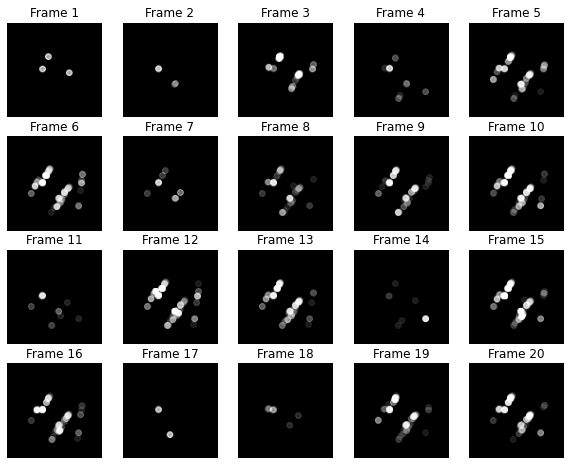

In [9]:
# Construct a figure on which we will visualize the images.
fig, axes = plt.subplots(4, 5, figsize=(10, 8))

# Plot each of the sequential images for one random data example.
data_choice = np.random.choice(range(len(train_dataset)), size=1)[0]
for idx, ax in enumerate(axes.flat):
    img = train_dataset[data_choice+idx]#[idx]
    #print(img.shape)
    ax.imshow(img, cmap="gray")
    ax.set_title(f"Frame {idx + 1}")
    ax.axis("off")

# Print information and display the figure.
print(f"Displaying frames for example {data_choice}.")
plt.show()

In [11]:
# Construct the input layer with no definite frame size.
print(*x_train.shape[1:])
#inp = layers.Input(shape=(None, *x_train.shape[1:]))
inp = layers.Input(shape=(None, *x_train.shape[2:]))

# We will construct 3 `ConvLSTM2D` layers with batch normalization,
# followed by a `Conv3D` layer for the spatiotemporal outputs.
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(5, 5),
    padding="same",
    return_sequences=True,
    activation="relu",
    name="ConvLSTM2D_1",
    data_format="channels_last"
)(inp)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=True,
    activation="relu",
    name="ConvLSTM2D_2",
    data_format="channels_last"
)(x)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(1, 1),
    padding="same",
    return_sequences=True,
    activation="relu",
    name="ConvLSTM2D_3",
    data_format="channels_last"
)(x)
x = layers.Conv3D(
    filters=1, kernel_size=(3, 3, 3), activation="sigmoid", padding="same",
    name="ConvLSTM3D",
    data_format="channels_last"
)(x)

# Next, we will build the complete model and compile it.
model = keras.models.Model(inp, x)
model.compile(
    loss=keras.losses.mse, optimizer=keras.optimizers.Adam(1e-5),
)

100 100


ValueError: Input 0 of layer ConvLSTM2D_1 is incompatible with the layer: expected ndim=5, found ndim=3. Full shape received: (None, None, 100)

In [13]:
print(x_train.shape)
X_train = np.expand_dims(x_train,axis=0)
X_train = np.expand_dims(X_train,axis=4)
print(X_train.shape)

print(y_train.shape)
Y_train = np.expand_dims(y_train,axis=0)
Y_train = np.expand_dims(Y_train,axis=4)
print(Y_train.shape)

x_val = np.expand_dims(x_val, axis=0)
x_val = np.expand_dims(x_val, axis=4)

y_val = np.expand_dims(y_val, axis=0)
y_val = np.expand_dims(y_val, axis=4)

(134, 100, 100)
(1, 134, 100, 100, 1)
(134, 100, 100)
(1, 134, 100, 100, 1)


In [14]:
#### Define some callbacks to improve training.
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=2)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=2)

# Define modifiable training hyperparameters.
epochs = 20
batch_size = 5

# Fit the model to the training data.
model.fit(
    X_train,
    Y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)


Epoch 1/20
1/1 [==============================] - 30s 30s/step - loss: 0.2372 - val_loss: nan
Epoch 2/20
1/1 [==============================] - 27s 27s/step - loss: nan - val_loss: nan


In [15]:
model.save('../models/cnnlstm1')

INFO:tensorflow:Assets written to: ../models/cnnlstm1/assets


In [16]:
example = val_dataset[np.random.choice(range(len(val_dataset)), size=1)[0]]

# Pick the first/last ten frames from the example.
frames = example[:10, ...]
original_frames = example[10:, ...]

# Predict a new set of 10 frames.
for _ in range(10):
    # Extract the model's prediction and post-process it.
    new_prediction = model.predict(np.expand_dims(frames, axis=0))
    new_prediction = np.squeeze(new_prediction, axis=0)
    predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

    # Extend the set of prediction frames.
    frames = np.concatenate((frames, predicted_frame), axis=0)

# Construct a figure for the original and new frames.
fig, axes = plt.subplots(2, 10, figsize=(20, 4))

# Plot the original frames.
for idx, ax in enumerate(axes[0]):
    ax.imshow(np.squeeze(original_frames[idx]), cmap="gray")
    ax.set_title(f"Frame {idx + 11}")
    ax.axis("off")

# Plot the new frames.
new_frames = frames[10:, ...]
for idx, ax in enumerate(axes[1]):
    ax.imshow(np.squeeze(new_frames[idx]), cmap="gray")
    ax.set_title(f"Frame {idx + 11}")
    ax.axis("off")

# Display the figure.
plt.show()

ValueError: in user code:

    /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1569 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1559 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/distribute/distribute_lib.py:1285 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/distribute/distribute_lib.py:2833 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/distribute/distribute_lib.py:3608 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1552 run_step  **
        outputs = model.predict_step(data)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1525 predict_step
        return self(x, training=False)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/base_layer.py:1030 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/functional.py:421 call
        inputs, training=training, mask=mask)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/functional.py:556 _run_internal_graph
        outputs = node.layer(*args, **kwargs)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/layers/recurrent.py:668 __call__
        return super(RNN, self).__call__(inputs, **kwargs)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/base_layer.py:1013 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/input_spec.py:219 assert_input_compatibility
        str(tuple(shape)))

    ValueError: Input 0 of layer ConvLSTM2D_1 is incompatible with the layer: expected ndim=5, found ndim=3. Full shape received: (None, 10, 100)
